# Analysis of Kernel Features

This notebook analyzes the results of the static analysis of CUDA kernels, showing the distribution of various features.

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the classification results
with open('classification_results.json', 'r') as f:
    data = json.load(f)

In [3]:
# Extract the feature counts
feature_counts = {
    "Float Division": 0,
    "External Function Calls": 0,
    "Recursion": 0,
    "Warp Divergence": 0,
    "Data-Dependent\nWarp Divergence": 0,
    "Common Subexpression": 0,
    "Special Math Function": 0,
    "No Features\n(except warp divergence)": 0
}

for targetName, file_dict in data.items():
    for filename, kernels in file_dict.items():
        for kernel in kernels:
            result = kernel
            has_any_feature = False
            if result['has_float_division']:
                feature_counts["Float Division"] += 1
                has_any_feature = True
            if result['has_external_function_calls']:
                feature_counts["External Function Calls"] += 1
                has_any_feature = True
            if result['has_recursion']:
                feature_counts["Recursion"] += 1
                has_any_feature = True
            if result['has_warp_divergence']:
                feature_counts["Warp Divergence"] += 1
                #has_any_feature = True
            if result['has_data_dependent_warp_divergence']:
                feature_counts["Data-Dependent\nWarp Divergence"] += 1
                has_any_feature = True
            if result['has_common_subexpression']:
                feature_counts["Common Subexpression"] += 1
                has_any_feature = True
            if result['has_special_math_function']:
                feature_counts["Special Math Function"] += 1
                has_any_feature = True
            
            if not has_any_feature:
                feature_counts["No Features\n(except warp divergence)"] += 1

df = pd.DataFrame(list(feature_counts.items()), columns=['Feature', 'Number of Kernels'])
df = df.sort_values(by='Number of Kernels', ascending=False)

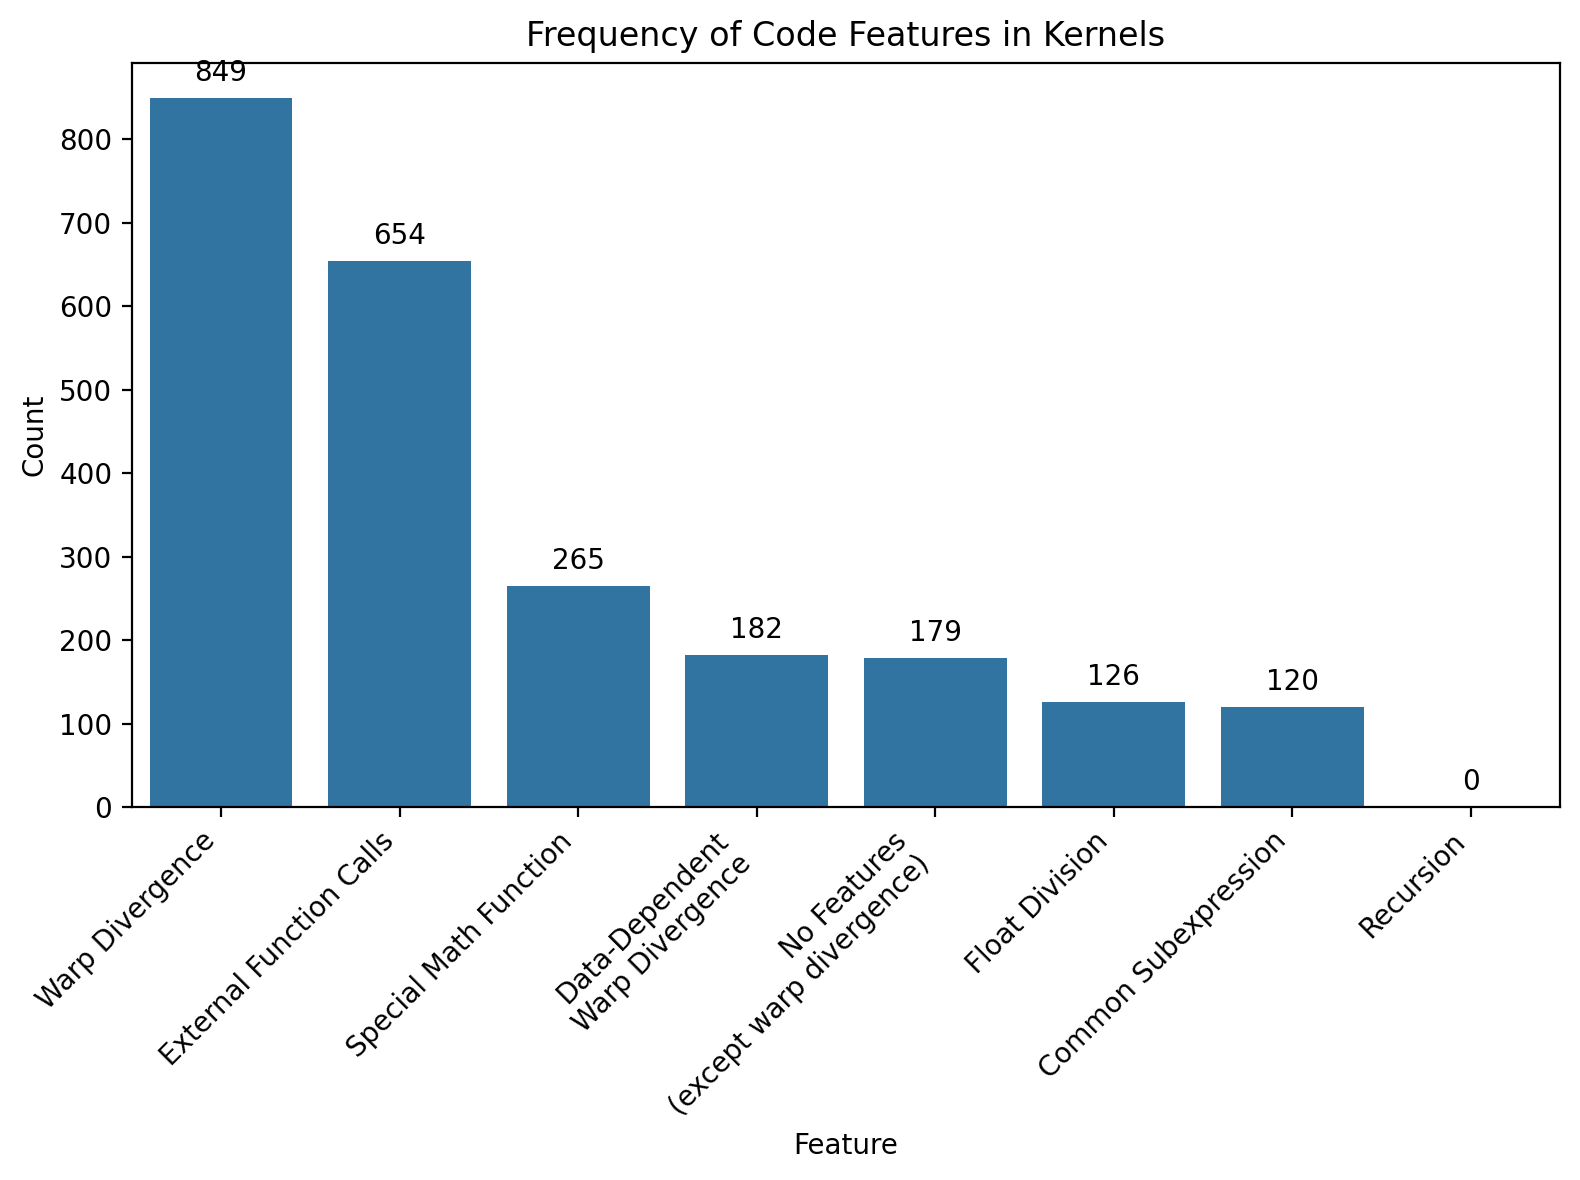

In [4]:
# Create the histogram
plt.figure(figsize=(8, 6), dpi=200)
ax = sns.barplot(x='Feature', y='Number of Kernels', data=df)
plt.title('Frequency of Code Features in Kernels')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')

plt.tight_layout()
plt.show()

In [5]:
# Print the first 10 kernels with no features
no_features_kernels = []
for targetName, file_dict in data.items():
    for filename, kernels in file_dict.items():
        for kernel in kernels:
            result = kernel
            has_any_feature = (
                result['has_float_division'] or
                result['has_external_function_calls'] or
                result['has_recursion'] or
                result['has_data_dependent_warp_divergence'] or
                result['has_common_subexpression'] or
                result['has_special_math_function']
            )
            
            if not has_any_feature:
                no_features_kernels.append({
                    'targetName': targetName,
                    'filename': filename,
                    'source_code': kernel['source_code']
                })

print("Kernels with 'No Features (except warp divergence)':")
for i, kernel_info in enumerate(no_features_kernels[:50]):
    print(f"\n\n--- Kernel {i+1} ---")
    print(f"Target: {kernel_info['targetName']}")
    print(f"File: {kernel_info['filename']}")
    print(kernel_info['source_code'])
    print("\n")

Kernels with 'No Features (except warp divergence)':


--- Kernel 1 ---
Target: particlefilter-cuda
File: /Users/gbolet/hecbench-roofline/src/particlefilter-cuda/kernel_sum.h
__global__ void
kernel_sum (float* partial_sums, const int Nparticles)
{
  int x;
  float sum = 0;
  int num_blocks = (Nparticles + BLOCK_SIZE - 1) / BLOCK_SIZE;
  for (x = 0; x < num_blocks; x++) {
    sum += partial_sums[x];
  }
  partial_sums[0] = sum;
}




--- Kernel 2 ---
Target: matrixT-cuda
File: /Users/gbolet/hecbench-roofline/src/matrixT-cuda/main.cu
__global__ void copy(
        float *__restrict__ odata,
  const float *__restrict__ idata,
  int width, int height)
{
  int xIndex = blockIdx.x * TILE_DIM + threadIdx.x;
  int yIndex = blockIdx.y * TILE_DIM + threadIdx.y;

  int index  = xIndex + width*yIndex;

  for (int i=0; i<TILE_DIM; i+=BLOCK_ROWS)
  {
    odata[index+i*width] = idata[index+i*width];
  }
}




--- Kernel 3 ---
Target: matrixT-cuda
File: /Users/gbolet/hecbench-roofline/src/matrixT-cuda/